<div style='text-align: center;'>
    <img src='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSQzJzIHdangJTrH2mFXFgsLjuLCjpfXXwbxg&usqp=CAU' width='100'/>
    <h1>Sharif University of Technology</h1>
    <h2>Natural Language Processing</h2>
    <h3>Final Project</h3>
    <h4>Spoiler classification and summary generation</h4>
    <p><strong>Authors:</strong> Ali Nikkhah, Ramtin Khoshnevis, Sarina Zahedi</p>
    <p><strong>(Equal Contribution)</strong></p>
</div>
<hr/>


In [1]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

--------------------------------------------------------------------------------------------------------------------------------------


### **1. Load the Dataset**


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current direct

/kaggle/input/IMDB_movie_details.json
/kaggle/input/IMDB_reviews.json


In [4]:
import pandas as pd
import json
import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the dataset
file_path = '/kaggle/input/IMDB_reviews.json'
data = []
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)


### **2. Exploratory Data Analysis (EDA)**

In [5]:
from tabulate import tabulate
import numpy as np

# Basic info
info = df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  object
 6   review_summary  573913 non-null  object
dtypes: bool(1), object(6)
memory usage: 26.8+ MB


In [6]:
# Describe the dataset
description = df.describe()


# Check for missing values
missing_values = df.isnull().sum()


# Distribution of spoiler vs. non-spoiler
spoiler_distribution = df['is_spoiler'].value_counts(normalize=True)

# Length of reviews
df['review_length'] = df['review_text'].apply(len)
review_length_description = df['review_length'].describe()



In [7]:
# Display the results

print("\nMissing Values:")
print(tabulate(missing_values.items(), headers=["Column", "Missing Values"], tablefmt="pretty"))

print("\nSpoiler vs. Non-Spoiler Distribution:")
print(tabulate(spoiler_distribution.items(), headers=["Is Spoiler", "Proportion"], tablefmt="pretty"))

print("\nReview Length Description:")
print(tabulate(review_length_description.items(), headers=["Statistic", "Value"], tablefmt="pretty"))


Missing Values:
+----------------+----------------+
|     Column     | Missing Values |
+----------------+----------------+
|  review_date   |       0        |
|    movie_id    |       0        |
|    user_id     |       0        |
|   is_spoiler   |       0        |
|  review_text   |       0        |
|     rating     |       0        |
| review_summary |       0        |
+----------------+----------------+

Spoiler vs. Non-Spoiler Distribution:
+------------+---------------------+
| Is Spoiler |     Proportion      |
+------------+---------------------+
|   False    | 0.7370263437141169  |
|    True    | 0.26297365628588304 |
+------------+---------------------+

Review Length Description:
+-----------+--------------------+
| Statistic |       Value        |
+-----------+--------------------+
|   count   |      573913.0      |
|   mean    | 1460.5535246631457 |
|    std    | 1125.577018615146  |
|    min    |        18.0        |
|    25%    |       719.0        |
|    50%    |     

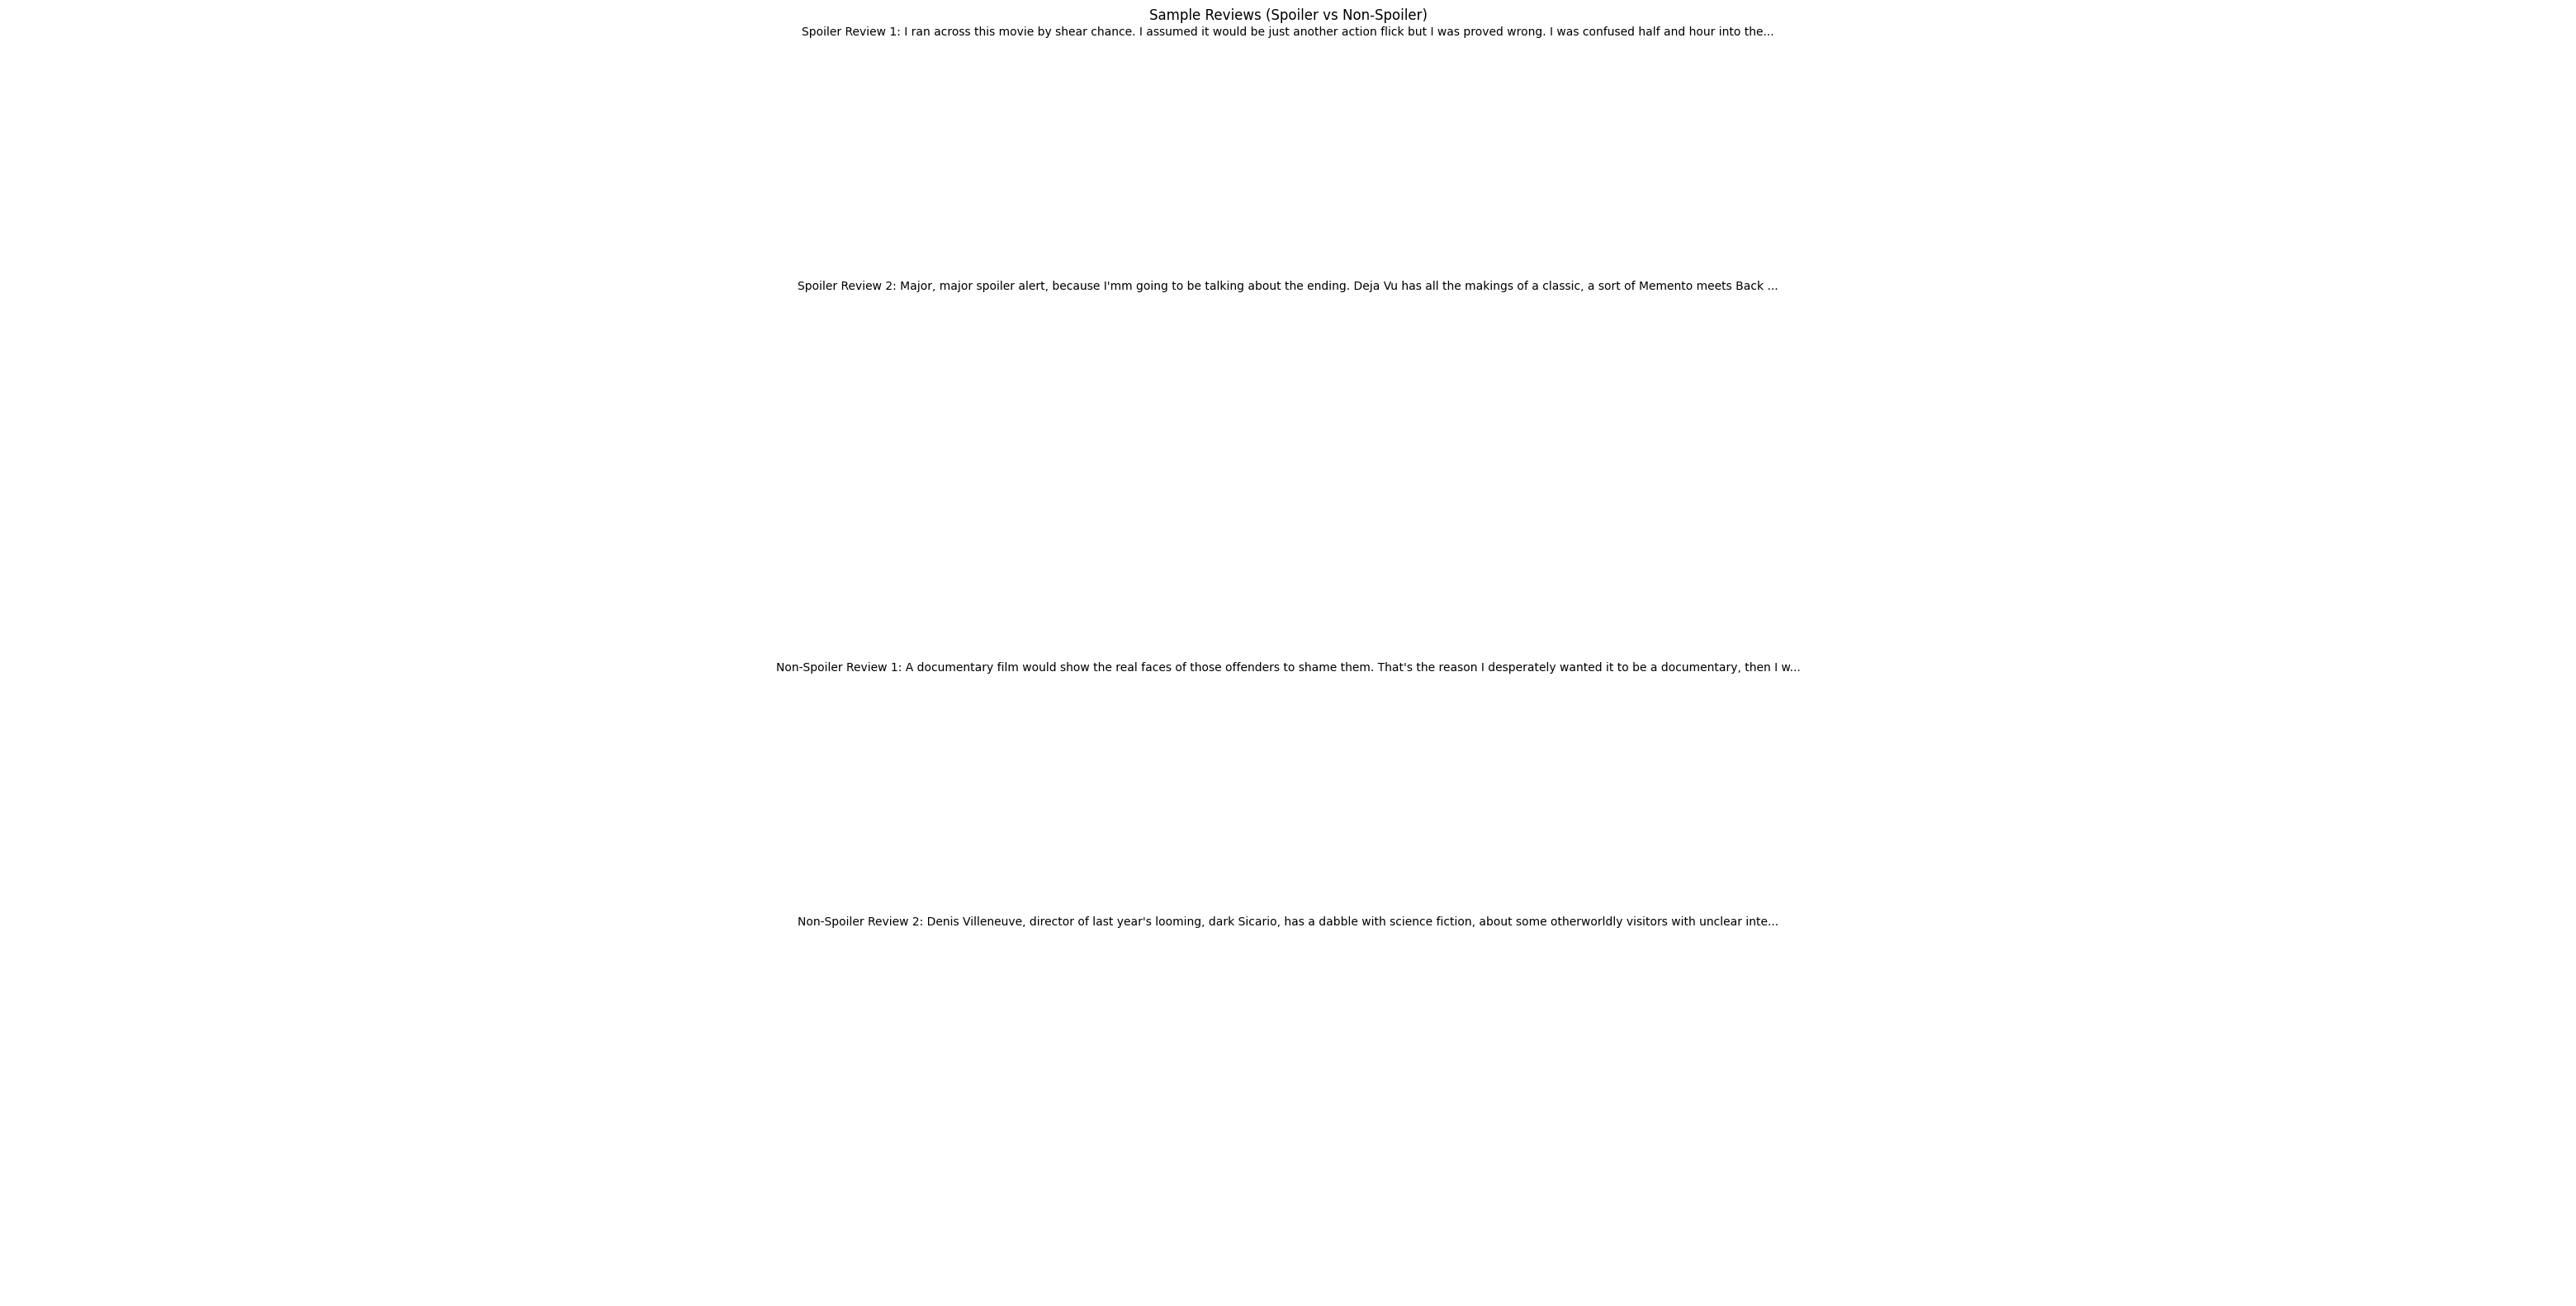

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot some samples of the dataset
sample_size = 2

spoiler_samples = df[df['is_spoiler'] == True].sample(sample_size)
non_spoiler_samples = df[df['is_spoiler'] == False].sample(sample_size)

plt.figure(figsize=(40, 20))

# Spoiler samples
for i, review in enumerate(spoiler_samples['review_text']):
    plt.text(0.5, 1.0 - i*0.2, f"Spoiler Review {i+1}: {review[:150]}...", ha='center', va='top', wrap=True)

# Non-Spoiler samples
for i, review in enumerate(non_spoiler_samples['review_text']):
    plt.text(0.5, 0.5 - i*0.2, f"Non-Spoiler Review {i+1}: {review[:150]}...", ha='center', va='top', wrap=True)

plt.axis('off')
plt.title('Sample Reviews (Spoiler vs Non-Spoiler)')
plt.show()


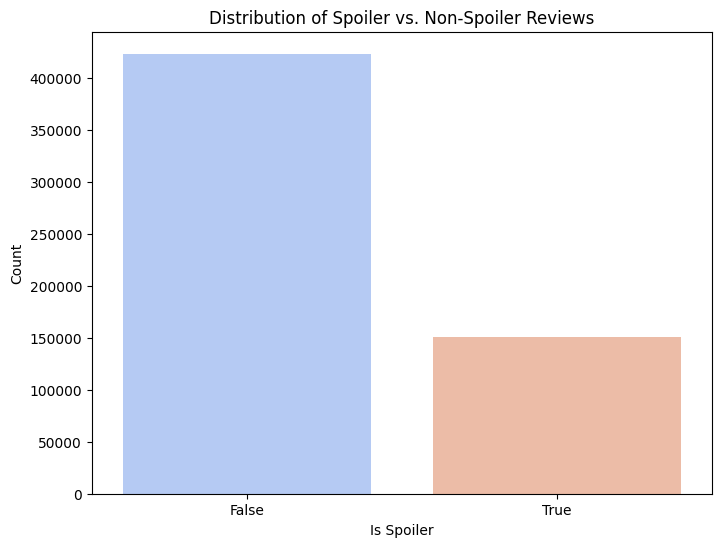

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


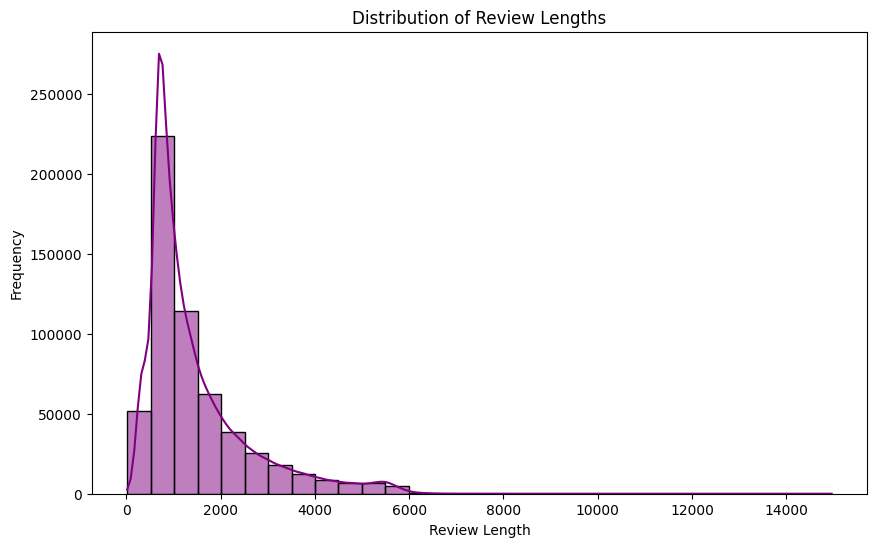

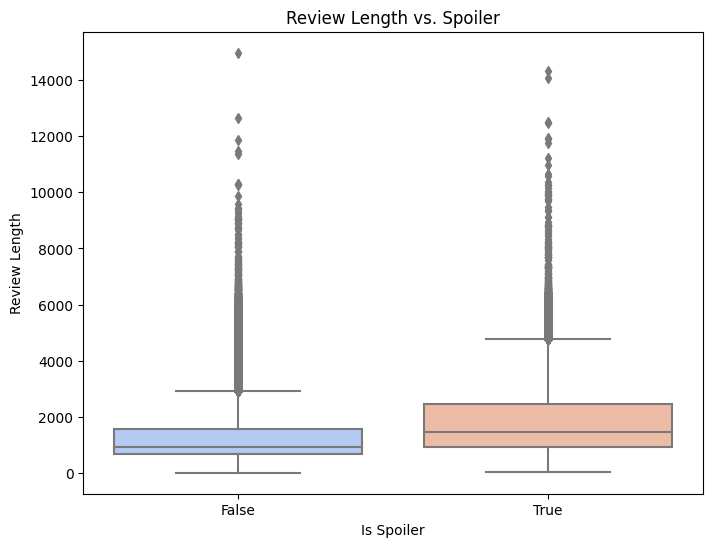

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of spoilers vs. non-spoilers
plt.figure(figsize=(8, 6))
sns.countplot(x='is_spoiler', data=df, palette='coolwarm')
plt.title('Distribution of Spoiler vs. Non-Spoiler Reviews')
plt.xlabel('Is Spoiler')
plt.ylabel('Count')
plt.show()

# Plot the distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], kde=True, bins=30, color='purple')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

# Correlation between review length and is_spoiler
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_spoiler', y='review_length', data=df, palette='coolwarm')
plt.title('Review Length vs. Spoiler')
plt.xlabel('Is Spoiler')
plt.ylabel('Review Length')
plt.show()


### **2.B. Rule based methods, spoiler contining frequent words and phrases**

In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm.notebook import tqdm
# Set of English stopwords
stop_words = set(stopwords.words('english'))

# Initialize the Porter Stemmer
stemmer = PorterStemmer()
# Initialize the Porter Stemmer
stemmer = PorterStemmer()

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    
    # Remove emails
    text = re.sub(r'\S*@\S*\s?', '', text)
    
    # Remove all non-word characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Normalize whitespaces
    text = re.sub(r'\s+', ' ', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords and apply stemming
    filtered_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    # Re-create text from filtered tokens
    text = ' '.join(filtered_tokens)
    return text
# Set up tqdm for pandas apply
tqdm.pandas(desc="Cleaning Text")

# Apply the cleaning function with a progress bar
df['cleaned_review_text'] = df['review_text'].progress_apply(clean_text)

Cleaning Text:   0%|          | 0/573913 [00:00<?, ?it/s]

In [11]:
# Specify the path where you want to save the JSON file
json_file_path = '/kaggle/working/preprocessed.json'  

# Save the DataFrame to a JSON file
df.to_json(json_file_path, orient='records', lines=True)

print(f"DataFrame saved successfully to {json_file_path}.")

DataFrame saved successfully to /kaggle/working/preprocessed.json.


In [17]:
import pandas as pd
# Specify the path where you want to save the JSON file
json_file_path = '/kaggle/working/preprocessed.json'  

# Save the DataFrame to a JSON file
df = pd.read_json(json_file_path, orient='records', lines=True)
first_df = df[0:150000]

In [25]:
all_freq = first_df.cleaned_review_text.str.split(expand=True).stack().value_counts()
spoiler_df = first_df.loc[first_df['is_spoiler'] == True]
non_spoiler_df = first_df.loc[first_df['is_spoiler'] == False]
spoiler_freq = spoiler_df.cleaned_review_text.str.split(expand=True).stack().value_counts()
non_spoiler_freq = non_spoiler_df.cleaned_review_text.str.split(expand=True).stack().value_counts()

temp_df = df[150000:300000]
for i in range(2):
    all_freq_here = temp_df.cleaned_review_text.str.split(expand=True).stack().value_counts()
    spoiler_df_here = temp_df.loc[temp_df['is_spoiler'] == True]
    non_spoiler_df_here = temp_df.loc[temp_df['is_spoiler'] == False]
    spoiler_freq_here = spoiler_df_here.cleaned_review_text.str.split(expand=True).stack().value_counts()
    non_spoiler_freq_here = non_spoiler_df_here.cleaned_review_text.str.split(expand=True).stack().value_counts()
    
    all_freq = pd.concat([all_freq, all_freq_here], axis=0)
    spoiler_freq = pd.concat([spoiler_freq, spoiler_freq_here], axis=0)
    non_spoiler_freq = pd.concat([non_spoiler_freq, non_spoiler_freq_here], axis=0)
    
    temp_df = df[150000*(i+2):min(len(df), 150000*(i+3))]

print(all_freq[0:10])
print(spoiler_freq[0:10])
print(non_spoiler_freq[0:10])

movi       402876
film       357682
one        186564
like       149123
charact    126483
time       122979
stori      112342
make       103075
watch      103052
see        101237
Name: count, dtype: int64
movi       120488
film       107295
one         59799
like        51009
charact     43687
time        38411
stori       34843
make        34248
see         33207
get         32606
Name: count, dtype: int64
movi       282388
film       250387
one        126765
like        98114
time        84568
charact     82796
stori       77499
watch       73456
make        68827
see         68030
Name: count, dtype: int64


In [26]:
x = spoiler_freq / len(df.loc[df['is_spoiler'] == True])
x[0:10]

movi       0.798336
film       0.710921
one        0.396219
like       0.337978
charact    0.289464
time       0.254506
stori      0.230865
make       0.226922
see        0.220025
get        0.216043
Name: count, dtype: float64

In [27]:
y = non_spoiler_freq / len(df.loc[df['is_spoiler'] == False])
y[0:10]

movi       0.667601
film       0.591947
one        0.299689
like       0.231954
time       0.199930
charact    0.195740
stori      0.183218
watch      0.173659
make       0.162716
see        0.160832
Name: count, dtype: float64